### Read saliency map and original image and convert to corresponding same format

## GuidedBackProp

In [6]:
# read original image in .nii.gz
import nibabel as nib
import numpy as np
import os
import itk
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    LoadImage,  # Adjusted from LoadImaged for direct image loading
    Rotate90,
    Flip,
    NormalizeIntensity,
    ThresholdIntensity,
    SpatialPad,
    Resize,
    Transpose,
)
image_shape = 301
depth = 40
val_transforms = Compose([
    LoadImage(image_only=True, ensure_channel_first=True, reader="ITKReader"),
    Rotate90(k=3),
    Flip(spatial_axis=1),
    NormalizeIntensity(subtrahend=15, divisor=85),
    ThresholdIntensity(threshold=0, above=True, cval=0.0),
    ThresholdIntensity(threshold=1, above=False, cval=0.0),
    SpatialPad(spatial_size=[-1, -1, depth], mode='constant', method="symmetric"),
    Resize(spatial_size=[image_shape, image_shape, depth]),
    # Transpose(indices=[0, 3, 1, 2])  # Adjust based on actual shape after previous transforms
])
# choose patientID to review
patientID = 12
label_name="POOR_PROGNOSIS"
map_type = "Guided-Grad-Cam"
layer="__feature_extractor.features.transition3.conv"
dir_saliency_map_prog="/home/ubuntu/tenerife/data/ZZ_ICH_PrognosisMICCAI/Results/BinaryGCS_BinaryAge_Prognosis/SaliencyMapsPrognosis/MedCam/Fold0/"+map_type+layer

saliency_map_path_prog=os.path.join(dir_saliency_map_prog, f"{patientID}_{map_type}-label-{label_name}.nii.gz")

saliency_map_nii_prog = nib.load(saliency_map_path_prog)
print("Shape saliency map prognosis:", saliency_map_nii_prog.shape)

dir_original_file=os.path.join("/home/ubuntu/tenerife/data/ICH_nii_StrippedSkull/", label_name)
original_file_path=os.path.join(dir_original_file, f'{patientID}_brain.nii.gz')
original_image_nii = itk.imread(original_file_path)
original_image = itk.GetArrayFromImage(original_image_nii)
print("Shape original image:", original_image_nii.shape)

dir_non_processed_file=os.path.join("/home/ubuntu/tenerife/data/ICH_nii/", label_name)
non_processed_file_path=os.path.join(dir_non_processed_file, f'{patientID}.nii.gz')
non_processed_image_nii = itk.imread(non_processed_file_path)
non_processed_image = itk.GetArrayFromImage(non_processed_image_nii)
print("Shape non processed image:", non_processed_image_nii.shape)


# Convert NIfTI to numpy arrays
saliency_map_prog = saliency_map_nii_prog.get_fdata()
processed_image = val_transforms(original_file_path)
# squeeze processed image to 3D
processed_image = np.squeeze(processed_image)
print("Shape processed image:", processed_image.shape)
non_processed_image=val_transforms(non_processed_file_path)
non_processed_image = np.squeeze(non_processed_image)
print("Shape non processed image:", non_processed_image.shape)

Shape saliency map prognosis: (301, 301, 40)
Shape original image: (32, 512, 512)
Shape non processed image: (32, 512, 512)
Shape processed image: (301, 301, 40)
Shape non processed image: (301, 301, 40)


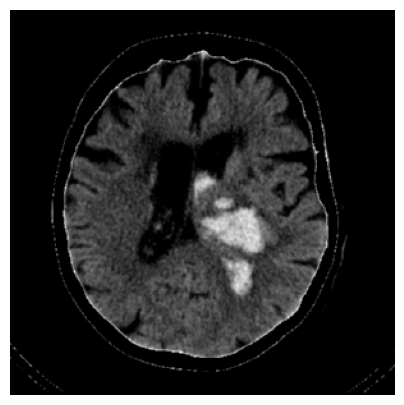

In [3]:
slice_index=20
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
# If resizing is not used, replace 'saliency_map_resized' with 'saliency_map' in the next line
axes.imshow(non_processed_image[:, :, slice_index], cmap='gray')
axes.axis('off')
plt.savefig('/home/ubuntu/tenerife/data/ZZ_ICH_PrognosisMICCAI/FiguresPaperMICCAI/non_processed_image_patient_'+str(patientID)+'.png')

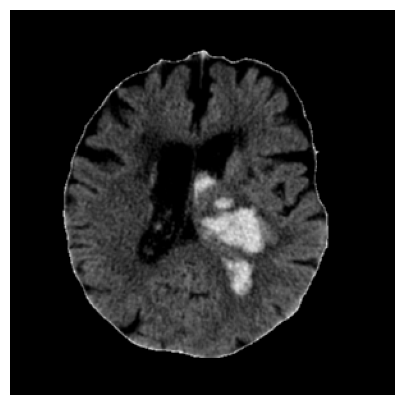

In [4]:
slice_index=20
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
# If resizing is not used, replace 'saliency_map_resized' with 'saliency_map' in the next line
axes.imshow(processed_image[:, :, slice_index], cmap='gray')
axes.axis('off')
plt.savefig('/home/ubuntu/tenerife/data/ZZ_ICH_PrognosisMICCAI/FiguresPaperMICCAI/processed_image_patient_'+str(patientID)+'.png')

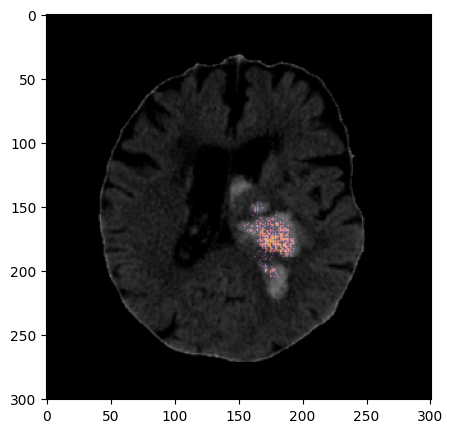

In [7]:
slice_index=20
saliency_map_normalized_prog = (saliency_map_prog - np.min(saliency_map_prog)) / (np.max(saliency_map_prog) - np.min(saliency_map_prog))
# convert background of saliency_map to 0
saliency_map_normalized_prog[saliency_map_normalized_prog < 0.5] = 0
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(processed_image[:, :, slice_index], cmap='gray')
ax.imshow(saliency_map_normalized_prog[:, :, slice_index], cmap='inferno', alpha=0.5)
axes.axis('off')
plt.savefig('/home/ubuntu/tenerife/data/ZZ_ICH_PrognosisMICCAI/FiguresPaperMICCAI/Guided-Grad-Cam_image_patient_'+str(patientID)+'.png')